# Regression with a Crab Age Dataset (Kaggle Competition)
In this notebook, I will develop a machine learning model to predict the age of crabs based on their physical measurements. This is a regression problem where I'll use various morphometric features (length, diameter, height, weight components) to estimate crab age. My methodology will include:
- **Exploratory Data Analysis**
- **Data Cleaning**
- **Data Visalisation**
- **Feature Engineering**
- **Data Preprocessing Pipelines**
- **Hyperparameter Optimisation**
- **XGBoost Model Training**

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

In [39]:
# Load data
train_df = pd.read_csv("/kaggle/input/playground-series-s3e16/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e16/test.csv")
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


## EDA: Descriptive Statistics

Some domain research and general knowledge allows me to get a better understanding on exactly what each feature is and how the measurements were taken: 
    
    Sex: Sex of the crab.
	•	M: Male
	•	F: Female
	•	I: Infant (sex undetermined)
	
    Length: Longest shell dimension [mm]
	•	Measured from the anterior (head) to posterior (tail) end.
	
    Diameter: Shell width perpendicular to length [mm]
	•	Width at the midpoint of the crab’s body.
	
    Height: Shell height with crab in natural resting position [mm]
	•	Vertical thickness including shell curvature.
	
    Weight: Whole body weight of the crab [g]
	•	Total weight including meat, viscera and shell.
	
    Shucked Weight: Weight of edible meat extracted [g]
	•	Used to assess meat yield and body condition.
	
    Viscera Weight: Weight of internal organs after shucking [g]
	•	Includes gut, hepatopancreas, etc.
	
    Shell Weight: Weight of the hard outer shell after drying [g]
	•	Often used to infer maturity and calcification.

In [40]:
train_df.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


From the above cell, I extracted the following key insights:

- Crab age ranges from 1 to 29. From this we can infer the dataset likely used red king crabs, which  have an average life expectancy of 20 years but can live until 30 in rare cases
  
- The minimum height is 0, which isn't physically possible - this data will need to be cleaned later on
  
- Height has the highest coefficient of variation, likely due to a large number of invalid 0s
  
- Shucked weight makes up the highest proportion of the total weight, viscera weight makes up the least
  
- There don't seem to be any missing values
  
- There are some outliers which will need to be dealt with e.g the maximum height is almost 9x the mean

## Data Cleaning

In [26]:
(train_df == 0).sum()

id                 1
Sex                0
Length             0
Diameter           0
Height            24
Weight             0
Shucked Weight     0
Viscera Weight     0
Shell Weight       0
Age                0
dtype: int64

The above code cell shows that height is the only column with invalid 0s. Fortunately, there are only 24 rows like this, which makes up about 0.03% of the data. As a result, it should be safe to just drop these records:

In [ ]:
print(f"Removing {(train_df['Height'] == 0).sum()} rows with zero height")
train_df = train_df[train_df['Height'] != 0]

Whilst scanning through the data, I noticed another data quality issue where the sum of the component weights (shell, shucked and viscera) exceeded the total weight. This is also physically impossible and this data will need to be cleaned. After further inspection through the above code cell, I found out that a large amount of the data is inaccurate. meaning I cannot simply just drop the invalid fields. Instead, I will scale the component weights proportionally to match the total in the following code cell.

In [11]:
# Check the extent of the problem
df = train_df.copy()
df['weight_sum'] = df['Shucked Weight'] + df['Viscera Weight'] + df['Shell Weight']
df['weight_diff'] = df['weight_sum'] - df['Weight']
invalid_rows = df[df['weight_diff'] > 0]

print(f"Invalid rows: {len(invalid_rows)} out of {len(df)} ({len(invalid_rows)/len(df)*100:.1f}%)")
print(f"Average excess weight: {invalid_rows['weight_diff'].mean():.4f}")
print(f"Max excess weight: {invalid_rows['weight_diff'].max():.4f}")

Invalid rows: 8932 out of 74051 (12.1%)
Average excess weight: 0.5774
Max excess weight: 13.8346


In [38]:
def fix_weight_inconsistency(df):
    df = df.copy()
    
    # Calculate component sum
    component_sum = df['Shucked Weight'] + df['Viscera Weight'] + df['Shell Weight']
    
    # Find rows where components > total weight
    invalid_mask = component_sum > df['Weight']
    
    # Scale components proportionally for invalid rows
    scaling_factor = df.loc[invalid_mask, 'Weight'] / component_sum[invalid_mask]
    
    df.loc[invalid_mask, 'Shucked Weight'] *= scaling_factor
    df.loc[invalid_mask, 'Viscera Weight'] *= scaling_factor  
    df.loc[invalid_mask, 'Shell Weight'] *= scaling_factor
    
    print(f"Fixed {invalid_mask.sum()} rows with proportional scaling")
    return df


print("\nBefore validation:")
print(f"Max Meat_Ratio: {(train_df['Shucked Weight'] / train_df['Weight']).max():.4f}")
print(f"Max Shell_Ratio: {(train_df['Shell Weight'] / train_df['Weight']).max():.4f}")
print(f"Max Viscera_Ratio: {(train_df['Viscera Weight'] / train_df['Weight']).max():.4f}")

# Apply the fix
train_df = fix_weight_inconsistency(train_df)

# Check ratios are now valid 
print("\nAfter validation:")
print(f"Max Meat_Ratio: {(train_df['Shucked Weight'] / train_df['Weight']).max():.4f}")
print(f"Max Shell_Ratio: {(train_df['Shell Weight'] / train_df['Weight']).max():.4f}")
print(f"Max Viscera_Ratio: {(train_df['Viscera Weight'] / train_df['Weight']).max():.4f}")


Before validation:
Max Meat_Ratio: 4.7251
Max Shell_Ratio: 2.6157
Max Viscera_Ratio: 1.3236
Fixed 8932 rows with proportional scaling

After validation:
Max Meat_Ratio: 0.9384
Max Shell_Ratio: 0.8030
Max Viscera_Ratio: 0.5143


The fix_weight_inconsistency function seems to have worked as the ratios are now all below 1.

## EDA: Data Visualisation 
To aid in creating new features, transforming existing features and identifying which columns have the strongest correlation with age, I have decided to create the following visualisations.

In [7]:
# Analyse a feature's distribution and relationship with the target variable
def graph_analysis(df, feature, target):
    print(f"\n{feature} Graphs:")
    
    print(f"Skewness: {df[feature].skew():.3f}")
    # negative = left-skewed, positive = right-skewed
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left plot: Histogram to show distribution shape
    axes[0].hist(df[feature], bins=30)
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("quantity")
    axes[0].set_title(f'{feature} Distribution')

    # Right plot: Scatter plot to show relationship with target
    axes[1].scatter(df[feature], df[target], alpha=0.5)
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel(target)
    axes[1].set_title(f'{feature} vs {target}')
    
    plt.tight_layout()
    plt.show()


Length transformations:
Raw        0.612843
Log        0.612258
Sqrt       0.611949
Square     0.601913
Cube       0.581449
Inverse   -0.563346
dtype: float64

Length Graphs:
Skewness: -0.844


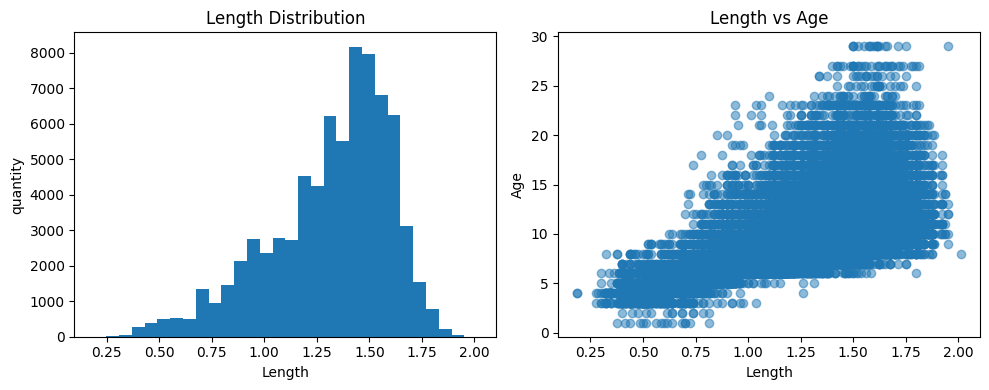


Diameter transformations:
Raw        0.621256
Log        0.620518
Sqrt       0.619725
Square     0.610558
Cube       0.589840
Inverse   -0.562610
dtype: float64

Diameter Graphs:
Skewness: -0.813


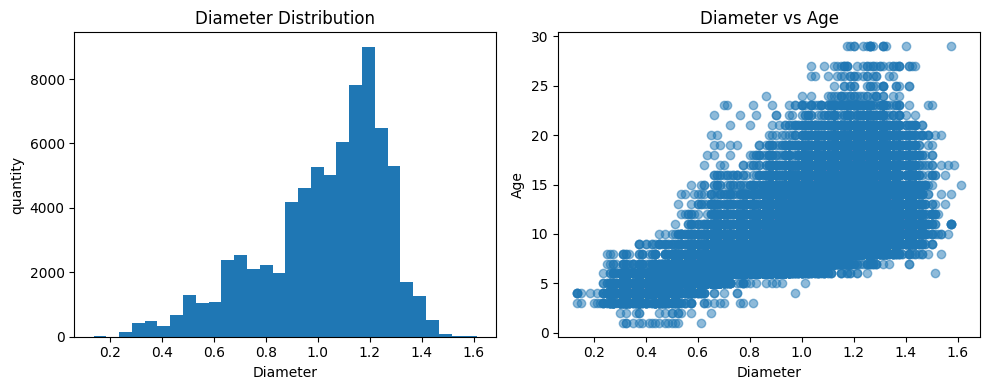


Height transformations:
Log        0.643672
Sqrt       0.642427
Raw        0.637759
Square     0.516358
Cube       0.158393
Inverse   -0.538946
dtype: float64

Height Graphs:
Skewness: 0.087


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


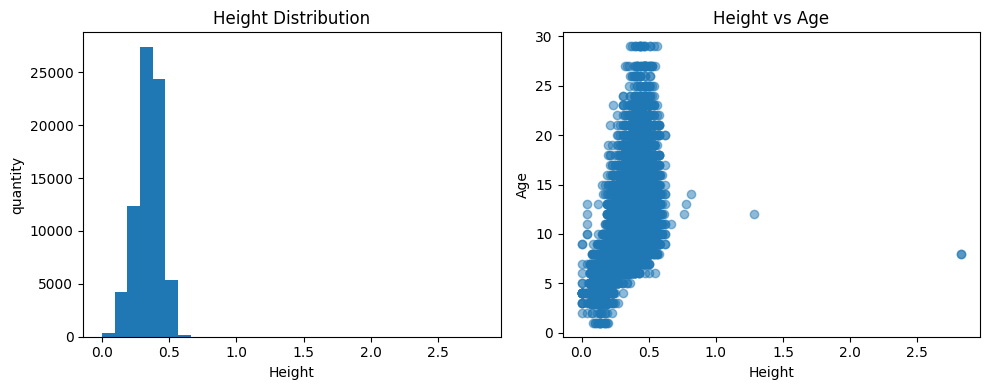


Weight transformations:
Log        0.629559
Sqrt       0.628753
Raw        0.601195
Square     0.515035
Cube       0.421981
Inverse   -0.358211
dtype: float64

Weight Graphs:
Skewness: 0.231


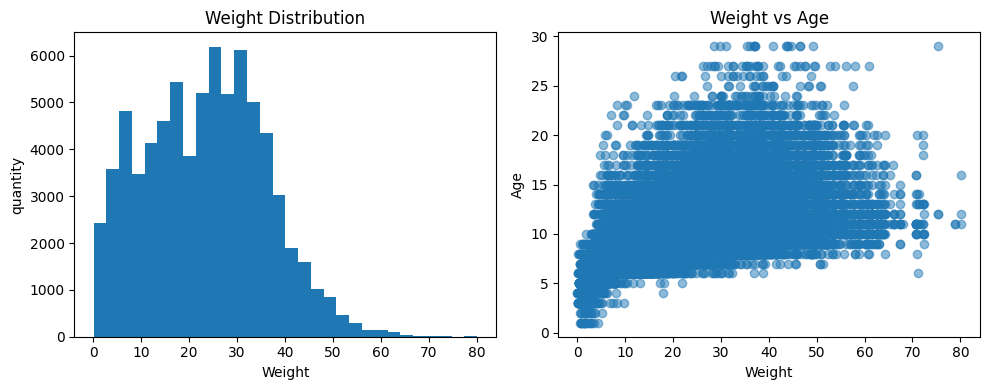


Shucked Weight transformations:
Log        0.569256
Sqrt       0.550648
Raw        0.503320
Square     0.393190
Cube       0.291632
Inverse   -0.349522
dtype: float64

Shucked Weight Graphs:
Skewness: 0.349


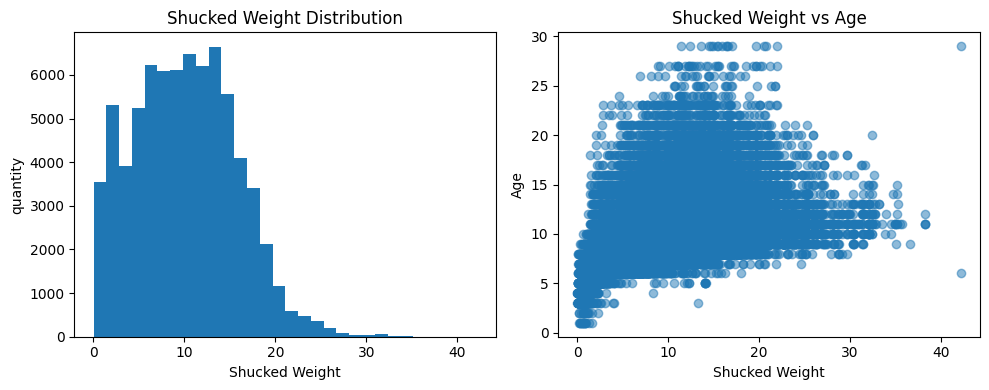


Viscera Weight transformations:
Log        0.618256
Sqrt       0.610611
Raw        0.576808
Square     0.482947
Cube       0.388093
Inverse   -0.402941
dtype: float64

Viscera Weight Graphs:
Skewness: 0.286


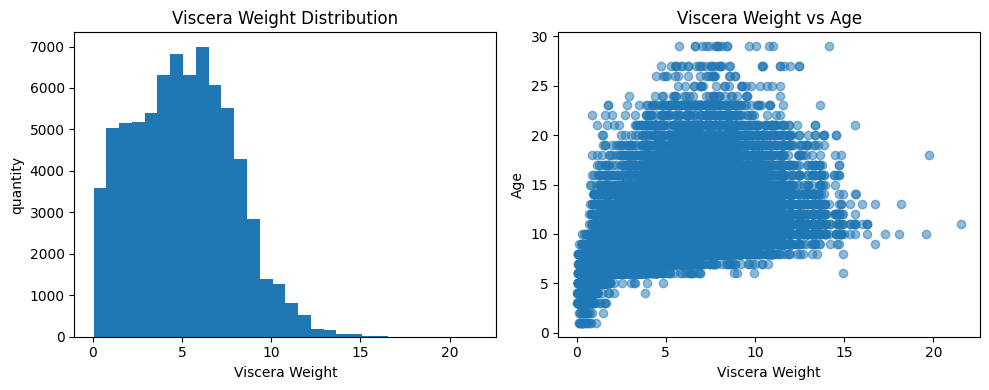


Shell Weight transformations:
Sqrt       0.677932
Log        0.673301
Raw        0.663473
Square     0.590272
Cube       0.491480
Inverse   -0.401316
dtype: float64

Shell Weight Graphs:
Skewness: 0.277


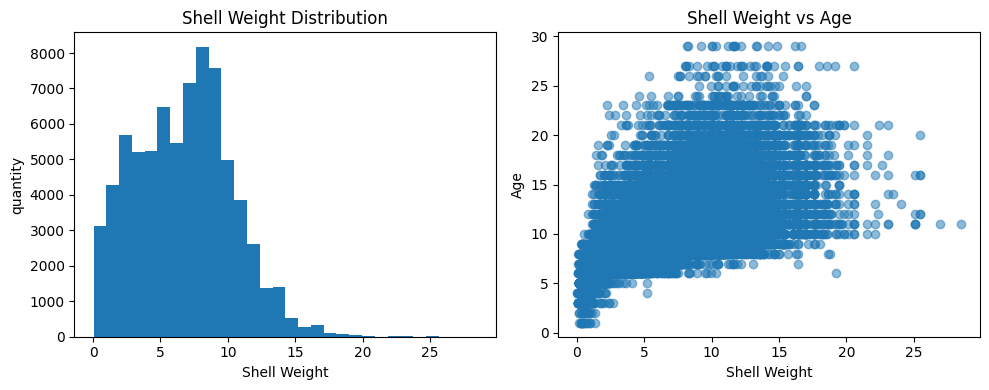

In [8]:
# Tests different mathematical transformations on a feature and return correlation with target variable to find the best transformation.
def test_transformations(df, feature, target):
    subset = train_df[[feature, target]].dropna()

    # Skip non-numeric data (like categorical variables)
    if not np.issubdtype(subset[feature].dtype, np.number):
        return pd.Series(dtype=float)

    x = subset[feature].replace(0, np.nan)  # for inverse
    
    # Dictionary of different transformations to test
    transformations = {
        'Raw': x,
        'Log': np.log1p(x.clip(lower=0)),
        'Sqrt': np.sqrt(x.clip(lower=0)),
        'Square': x**2,
        'Cube': x**3,
        'Inverse': 1/x
    }

    results = {}
    for name, transformed in transformations.items():
        results[name] = transformed.corr(subset[target])

    # Return correlations sorted by absolute value (strongest correlation first)
    return pd.Series(results).sort_values(ascending=False)

for column in test_df.select_dtypes(include=[np.number]).columns:
    if column == "id":
        continue
    print(f"\n{column} transformations:")
    print(test_transformations(train_df, column, "Age"))
    graph_analysis(train_df, column, "Age")

## Feature Engineering

The above analysis shows different metrics from which I can decide whether to transform a feature in order for for it to better "fit" to the target variable. The first metric is correlation (higher correlation = better fitting), the second is skewness (positive skewness means data is right-skewed and a log transformation is likely to be optimal), which can be visualised through the left-most graphs. The final metric shows the raw relationship between the feature and age with the line of best fit representing the optimal transformation. For example, a curved line of best fit implies a polynomial transformation may be best. I will encode my findings with the following function:

In [9]:
def apply_best_transforms(df):
    df = df.copy()
    
    # Log Transformations
    df['Height_Log'] = np.log1p(df['Height'])
    df['Weight_Log'] = np.log1p(df['Weight'])
    df['Shucked_Weight_Log'] = np.log1p(df['Shucked Weight'])
    df['Viscera_Weight_Log'] = np.log1p(df['Viscera Weight'])

    # Square Root Transformation
    df['Shell_Weight_Sqrt'] = np.sqrt(df['Shell Weight'])
    return df

Through research about the domain and some general knowledge, I was able to derive some features that may be able to improve the model's performance:

In [10]:
def add_features(df):
    df = df.copy()
    
    # Calculate basic component ratios relative to weight metrics
    df["Meat_Ratio"] = df["Shucked Weight"] / df["Weight"]  
    df["Shell_Ratio"] = df["Shell Weight"] / df["Weight"]   
    df["Viscera_Ratio"] = df["Viscera Weight"] / df["Weight"]  
    df["Meat_Shell_Ratio"] = df["Shucked Weight"] / df["Shell Weight"] 
    
    # Body condition
    df["Crab_BMI"] = df["Weight"] / (df["Length"] ** 2)  
    
    # Growth efficiency  
    df["Weight_per_Length"] = df["Weight"] / df["Length"] 

    # Key metric used by biologists to estimate crab age - higher value indicates better body condition
    df['Body Condition Index'] = np.sqrt(df['Length'] * df['Weight'] * df['Shucked Weight'])

    # Indicates body shape (elongated vs round)
    df['Len-to-Diam']= df['Length'] / df['Diameter']

    # Estimates internal body volume, assuming a roughly cylindrical shape
    df["Volume"] = df["Length"] * df["Diameter"] * df["Height"]

    return df

In [13]:
# apply transformations & feature engineering
train_df_enhanced = apply_best_transforms(train_df)
train_df_enhanced = add_features(train_df_enhanced)
test_df_enhanced = apply_best_transforms(test_df)
test_df_enhanced = add_features(test_df_enhanced)

# Split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_df_enhanced.drop("Age",axis=1), train_df_enhanced['Age'],
                                                    test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (59240, 25)
X_test shape: (14811, 25)


Now I will test if my derived features are any good by training a base model on the original training set plus one of the features, outputting an MAE score at the end. A flaw with this method of testing is it will not pick up on any interative relationships between multiple derived features so I won't judge the results entirely at face value.

In [22]:
# evaluate and list the derived features from most to least impactful
def evaluate_model(X_train, X_valid, y_train, y_valid):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

engineered_features = [
    "Meat_Ratio",
    "Shell_Ratio",
    "Viscera_Ratio",
    "Meat_Shell_Ratio",
    "Crab_BMI",
    "Weight_per_Length",
    "Body Condition Index",
    "Len-to-Diam",
    "Volume"
]

# redo train test split so originals aren't impacted during testing
X_full = train_df.drop("Age", axis=1)
y_full = train_df["Age"]
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

results = []

for feature in engineered_features:
    print(f"\nTesting feature: {feature}")
    
    # Apply feature engineering to raw data
    X_train_aug = add_features(X_train_raw.copy())
    X_train_aug = apply_best_transforms(X_train_aug.copy())
    X_valid_aug = add_features(X_valid_raw.copy())
    X_valid_aug = apply_best_transforms(X_valid_aug.copy())

    # Define the column sets including only the new engineered feature
    selected_cols = X_train_raw.columns.tolist() + [feature]
    selected_cols = list(dict.fromkeys(selected_cols))  # remove duplicates if any

    X_train_subset = X_train_aug[selected_cols]
    X_valid_subset = X_valid_aug[selected_cols]

    # Identify updated feature types
    new_numerical_cols = [col for col in selected_cols if X_train_aug[col].dtype in ['int64', 'float64']]
    new_categorical_cols = [col for col in selected_cols if X_train_aug[col].dtype == 'object']

    # Update preprocessing
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, new_numerical_cols),
        ('cat', categorical_transformer, new_categorical_cols)
    ])

    # Update pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Evaluate and record result
    mae = evaluate_model(X_train_subset, X_valid_subset, y_train, y_valid)
    print(f"{feature}: MAE = {mae:.4f}")
    results.append((feature, mae))

# Sort and display results
results.sort(key=lambda x: x[1])
print("\nFeature impact on MAE (lower is better):")
for feature, mae in results:
    print(f"{feature:25}: MAE = {mae:.4f}")


Testing feature: Meat_Ratio
Meat_Ratio: MAE = 1.4226

Testing feature: Shell_Ratio
Shell_Ratio: MAE = 1.4274

Testing feature: Viscera_Ratio
Viscera_Ratio: MAE = 1.4259

Testing feature: Meat_Shell_Ratio
Meat_Shell_Ratio: MAE = 1.4286

Testing feature: Crab_BMI
Crab_BMI: MAE = 1.4246

Testing feature: Weight_per_Length
Weight_per_Length: MAE = 1.4262

Testing feature: Body Condition Index
Body Condition Index: MAE = 1.4303

Testing feature: Len-to-Diam
Len-to-Diam: MAE = 1.4292

Testing feature: Volume
Volume: MAE = 1.4222

Feature impact on MAE (lower is better):
Volume                   : MAE = 1.4222
Meat_Ratio               : MAE = 1.4226
Crab_BMI                 : MAE = 1.4246
Viscera_Ratio            : MAE = 1.4259
Weight_per_Length        : MAE = 1.4262
Shell_Ratio              : MAE = 1.4274
Meat_Shell_Ratio         : MAE = 1.4286
Len-to-Diam              : MAE = 1.4292
Body Condition Index     : MAE = 1.4303


The above results show that the created features are in fact useful in lowering the MAE. Volume is the most impactful and Body Condition Index is the least. Since the scores are so close to one another, I have decided to keep all the features, though I may test the effect of discarding some of the less impactful features in the future.

## Preprocessing Pipeline & Model Pipeline Creation

The following cell includes the creation of a categorical and a numerical pipeline in order to deal with missing values, convert categorical values to numerical values that the ML model can understand via one-hot-encoding and also standardise the numerical values so mean = 0 & std = 1. This aligns features measures with different units onto similar scales, thereby preventing bias toward features with larger numerical ranges.

In [14]:
# Identify feature types
test_ids = test_df.copy()
categorical_cols = [cname for cname in X_train.columns
                    if X_train[cname].dtype == "object" 
                    and cname != 'id']  

numerical_cols = [cname for cname in X_train.columns
                  if X_train[cname].dtype in ['int64', 'float64']
                  and cname != 'id']  

cols = categorical_cols + numerical_cols

print(f"Selected {len(categorical_cols)} categorical features: {categorical_cols[:5]}...")
print(f"Selected {len(numerical_cols)} numerical features: {numerical_cols[:5]}...")
print(f"Total features: {len(cols)}")

# Numerical data pipeline
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical data pipeline
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combined preprocessing
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])
print("Preprocessing pipeline created\n")

# Model pipeline
model = XGBRegressor(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])
print("XGBoost model pipeline ready\n")

Selected 1 categorical features: ['Sex']...
Selected 23 numerical features: ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight']...
Total features: 24
Preprocessing pipeline created

XGBoost model pipeline ready



## Hyperparameter Optimisation

In [15]:
# specify which paramters to optimise
param_dist = {
    'model__n_estimators': randint(200, 1500),  # More trees for better performance
    'model__learning_rate': uniform(0.01, 0.19),  # Good range
    'model__max_depth': randint(4, 12),  # Slightly deeper for complex relationships
    'model__reg_alpha': uniform(0, 5),  # L1 regularization
    'model__reg_lambda': uniform(1, 50),  # L2 regularization - reduced range
    'model__subsample': uniform(0.7, 0.3),  # 0.7 to 1.0 - correct
    'model__colsample_bytree': uniform(0.6, 0.4),  # 0.6 to 1.0 - more feature variety
    'model__min_child_weight': randint(1, 10),  # Add this for overfitting control
    'model__gamma': uniform(0, 2),  # Add minimum split loss
}

# test a range of values for each parameter randomly to cover the high-dimensional paramter space efficiently
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=200,  
    cv=5,
    scoring='neg_mean_absolute_error',  
    n_jobs=-1, # use all cores available
    verbose=1,
    random_state=42,
    error_score='raise'
)

print("Randomized search configured with 200 iterations\n")

Randomized search configured with 200 iterations



## Model Training & Validation

In [18]:
# Model training
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("\nTraining complete!")
print(f"Best parameters: {random_search.best_params_}\n")

# Model validation
val_predictions = best_model.predict(valid)
val_mae = mean_absolute_error(y_test, val_predictions)
print("Validation MAE:", val_mae)

Fitting 5 folds for each of 150 candidates, totalling 750 fits

Training complete!
Best parameters: {'model__colsample_bytree': 0.6116989132138236, 'model__gamma': 1.6516335011295253, 'model__learning_rate': 0.03448527481995459, 'model__max_depth': 6, 'model__min_child_weight': 5, 'model__n_estimators': 281, 'model__reg_alpha': 4.0898351205953105, 'model__reg_lambda': 42.606708897887096, 'model__subsample': 0.8522403201282508}

Validation MAE: 1.4033935767538148


In [20]:
# Convert results into format that can be submitted to the competition
test_predictions = best_model.predict(test_df_enhanced)
output = pd.DataFrame({'id': test_df_enhanced["id"], 'Age': test_predictions})
output.to_csv('Submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!")
print(f"Predicted age range: {output['Age'].min():,.0f} to {output['Age'].max():,.0f} years")

Submission file 'submission.csv' created successfully!
Predicted age range: 4 to 19 years


## Summary & Next Steps
...